# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00
time: 348 µs (started: 2023-02-26 02:23:09 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, 
    Dense, Dropout, Input, Concatenate, 
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.7 s (started: 2023-02-26 02:23:09 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__)
print()

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/regular_otsu/
versión Keras: 2.11.0

time: 2.48 ms (started: 2023-02-26 02:23:13 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 17.7 s (started: 2023-02-26 02:23:13 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):
    '''Crea un modelo de Deep Learning
    '''
    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_8G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG,
               USE_DATA_AUG, DNN_NAME, ETL_DATASET):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG= regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME = Deep Neural Network's name like ResNet50 or DenseNet121
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_{ETL_DATASET.lower()}_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG + '/' + TYPE_IMG + '/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.08 ms (started: 2023-02-26 02:23:30 +00:00)


# Imgs 64x64

- Test Accuracy: 0.5137478709220886
- Test Loss: 2.672455310821533
- time: 30min 24s
- F1 score: 0.508018650692348
- Precision score: 0.5526506734335502
- Recall:  0.5137478849407784
- Epoch: 50/50



## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/regular_otsu/
time: 1.05 ms (started: 2023-02-26 02:24:06 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.95 s (started: 2023-02-26 02:24:06 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.22 ms (started: 2023-02-26 02:24:11 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 1s 0us/step
time: 5.76 s (started: 2023-02-26 02:24:11 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 48s 11ms/step - loss: 6.4919 - sparse_categorical_accuracy: 0.0302 - val_loss: 6.2273 - val_sparse_categorical_accuracy: 0.0617
Epoch 2/50
3325/3325 [==============================] - 36s 11ms/step - loss: 6.0156 - sparse_categorical_accuracy: 0.0958 - val_loss: 5.8638 - val_sparse_categorical_accuracy: 0.1141
Epoch 3/50
3325/3325 [==============================] - 36s 11ms/step - loss: 5.6827 - sparse_categorical_accuracy: 0.1443 - val_loss: 5.5814 - val_sparse_categorical_accuracy: 0.1506
Epoch 4/50
3325/3325 [==============================] - 36s 11ms/step - loss: 5.4144 - sparse_categorical_accuracy: 0.1830 - val_loss: 5.3512 - val_sparse_categorical_accuracy: 0.1767
Epoch 5/50
3325/3325 [==============================] - 36s 11ms/step - loss: 5.1887 - sparse_categorical_accuracy: 0.2160 - val_loss: 5.1544 - val_sparse_categorical_accuracy: 0.2083
Epoch 6/50
3325/3325 [==============================] - 36s 11ms/step - loss: 4.

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 649 ms (started: 2023-02-26 02:54:43 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 5s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5137478709220886
- Test Loss: 2.672455310821533
- time: 
- F1 score: 0.508018650692348
- Precision score: 0.5526506734335502
- Recall:  0.5137478849407784
- Epoch: 
*********************************************************************************************************************************
time: 9.66 s (started: 2023-02-26 02:54:43 +00:00)


## Graficando

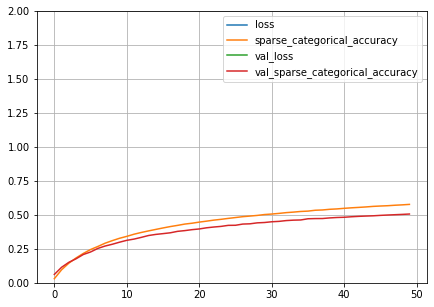

time: 226 ms (started: 2023-02-26 02:54:53 +00:00)


In [16]:
plot_loss(history)

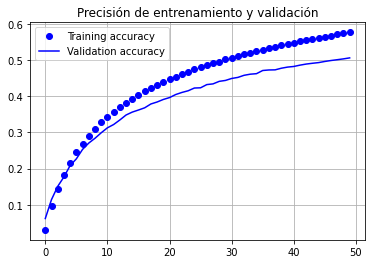

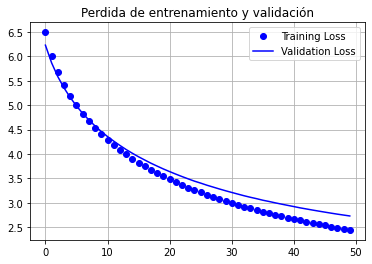

time: 254 ms (started: 2023-02-26 02:54:53 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl_8g_imgs64_regular__OTSU.h5
time: 2.33 s (started: 2023-02-26 02:54:53 +00:00)


# Imgs 96x96

- Test Accuracy: 0.6371968388557434
- Test Loss: 2.2200167179107666
- time: 36min 7s
- F1 score: 0.6361078768688408
- Precision score: 0.6701638956880527
- Recall:  0.6371968415115623
- Epoch: 50/50



## Cargar las imágenes

In [21]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_96/splits/regular_otsu/
time: 863 µs (started: 2023-02-26 02:57:29 +00:00)


In [22]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.71 s (started: 2023-02-26 02:57:30 +00:00)


In [23]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 1.27 ms (started: 2023-02-26 02:57:34 +00:00)


## Preparar el modelo

In [24]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.64 s (started: 2023-02-26 02:57:34 +00:00)


In [25]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [26]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 48s 14ms/step - loss: 6.5482 - sparse_categorical_accuracy: 0.0354 - val_loss: 6.3143 - val_sparse_categorical_accuracy: 0.0720
Epoch 2/50
3325/3325 [==============================] - 43s 13ms/step - loss: 6.1153 - sparse_categorical_accuracy: 0.1245 - val_loss: 5.9574 - val_sparse_categorical_accuracy: 0.1575
Epoch 3/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.7818 - sparse_categorical_accuracy: 0.1922 - val_loss: 5.6620 - val_sparse_categorical_accuracy: 0.2029
Epoch 4/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.4984 - sparse_categorical_accuracy: 0.2498 - val_loss: 5.4098 - val_sparse_categorical_accuracy: 0.2486
Epoch 5/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.2511 - sparse_categorical_accuracy: 0.2912 - val_loss: 5.1853 - val_sparse_categorical_accuracy: 0.2855
Epoch 6/50
3325/3325 [==============================] - 43s 13ms/step - loss: 5.

In [27]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 824 ms (started: 2023-02-26 03:33:44 +00:00)


In [28]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 6s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6371968388557434
- Test Loss: 2.2200167179107666
- time: 
- F1 score: 0.6361078768688408
- Precision score: 0.6701638956880527
- Recall:  0.6371968415115623
- Epoch: 
*********************************************************************************************************************************
time: 11.6 s (started: 2023-02-26 03:33:45 +00:00)


## Graficando

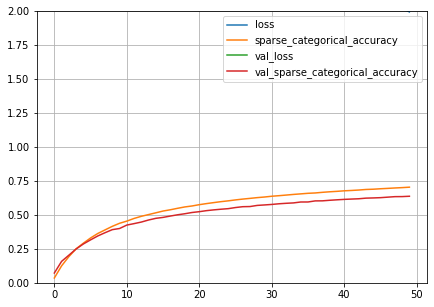

time: 146 ms (started: 2023-02-26 03:33:56 +00:00)


In [29]:
plot_loss(history)

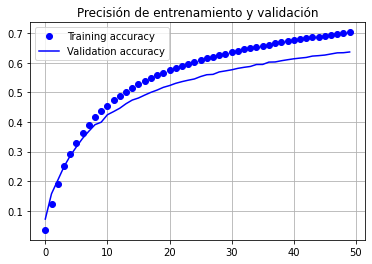

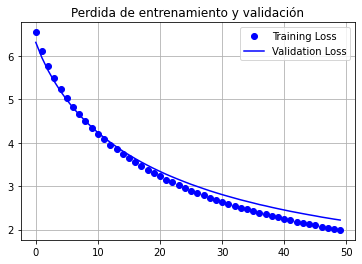

time: 244 ms (started: 2023-02-26 03:33:57 +00:00)


In [30]:
show_history(history)

In [31]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl_8g_imgs96_regular__OTSU.h5
time: 643 ms (started: 2023-02-26 03:33:57 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7546531558036804
- Test Loss: 1.2579569816589355
- time: 37min 52s
- F1 score: 0.7552528259408767
- Precision score: 0.7741240365728761
- Recall:  0.754653130287648
- Epoch: 50/50





## Cargar imágenes

In [33]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_112/splits/regular_otsu/
time: 1.24 ms (started: 2023-02-26 03:34:24 +00:00)


In [34]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.9 s (started: 2023-02-26 03:34:24 +00:00)


In [35]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 861 µs (started: 2023-02-26 03:34:30 +00:00)


## Preparar el modelo

In [36]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.63 s (started: 2023-02-26 03:34:30 +00:00)


In [37]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar modelo


In [38]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 50s 14ms/step - loss: 6.1419 - sparse_categorical_accuracy: 0.0568 - val_loss: 5.6728 - val_sparse_categorical_accuracy: 0.1212
Epoch 2/50
3325/3325 [==============================] - 45s 13ms/step - loss: 5.3264 - sparse_categorical_accuracy: 0.1833 - val_loss: 5.0795 - val_sparse_categorical_accuracy: 0.2167
Epoch 3/50
3325/3325 [==============================] - 45s 14ms/step - loss: 4.7976 - sparse_categorical_accuracy: 0.2729 - val_loss: 4.6439 - val_sparse_categorical_accuracy: 0.2859
Epoch 4/50
3325/3325 [==============================] - 45s 14ms/step - loss: 4.3892 - sparse_categorical_accuracy: 0.3419 - val_loss: 4.2895 - val_sparse_categorical_accuracy: 0.3566
Epoch 5/50
3325/3325 [==============================] - 45s 14ms/step - loss: 4.0532 - sparse_categorical_accuracy: 0.3962 - val_loss: 4.0037 - val_sparse_categorical_accuracy: 0.3831
Epoch 6/50
3325/3325 [==============================] - 45s 14ms/step - loss: 3.

In [39]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 889 ms (started: 2023-02-26 04:12:25 +00:00)


In [40]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 6s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7546531558036804
- Test Loss: 1.2579569816589355
- time: 
- F1 score: 0.7552528259408767
- Precision score: 0.7741240365728761
- Recall:  0.754653130287648
- Epoch: 
*********************************************************************************************************************************
time: 11.3 s (started: 2023-02-26 04:12:26 +00:00)


## Graficando

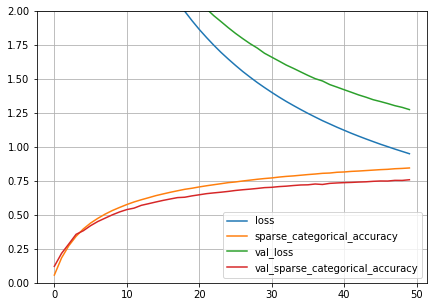

time: 152 ms (started: 2023-02-26 04:12:37 +00:00)


In [41]:
plot_loss(history)

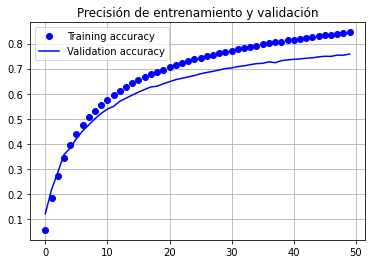

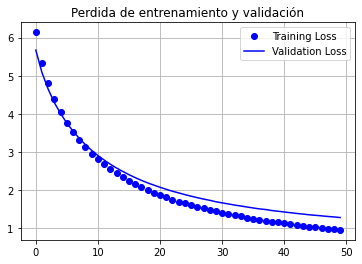

time: 249 ms (started: 2023-02-26 04:12:38 +00:00)


In [42]:
show_history(history)

In [43]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl_8g_imgs112_regular__OTSU.h5
time: 618 ms (started: 2023-02-26 04:12:38 +00:00)


# Imgs 127x127

- Test Accuracy: 0.6720952987670898
- Test Loss: 2.2579004764556885
- time: 38min 46s
- F1 score: 0.6724550067108199
- Precision score: 0.7112618013227077
- Recall:  0.6720953186689227
- Epoch: 50/50




## Cargar imágenes

In [45]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_127/splits/regular_otsu/
time: 1.38 ms (started: 2023-02-26 04:14:03 +00:00)


In [46]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 7.11 s (started: 2023-02-26 04:14:03 +00:00)


In [47]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 978 µs (started: 2023-02-26 04:14:10 +00:00)


## Preparar el modelo

In [48]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.96 s (started: 2023-02-26 04:14:10 +00:00)


In [49]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar modelo

In [50]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 51s 14ms/step - loss: 6.5925 - sparse_categorical_accuracy: 0.0277 - val_loss: 6.3824 - val_sparse_categorical_accuracy: 0.0575
Epoch 2/50
3325/3325 [==============================] - 46s 14ms/step - loss: 6.2074 - sparse_categorical_accuracy: 0.0996 - val_loss: 6.0628 - val_sparse_categorical_accuracy: 0.1309
Epoch 3/50
3325/3325 [==============================] - 46s 14ms/step - loss: 5.9064 - sparse_categorical_accuracy: 0.1638 - val_loss: 5.7910 - val_sparse_categorical_accuracy: 0.1809
Epoch 4/50
3325/3325 [==============================] - 46s 14ms/step - loss: 5.6464 - sparse_categorical_accuracy: 0.2203 - val_loss: 5.5560 - val_sparse_categorical_accuracy: 0.2202
Epoch 5/50
3325/3325 [==============================] - 46s 14ms/step - loss: 5.4180 - sparse_categorical_accuracy: 0.2677 - val_loss: 5.3479 - val_sparse_categorical_accuracy: 0.2692
Epoch 6/50
3325/3325 [==============================] - 46s 14ms/step - loss: 5.

## Graficando

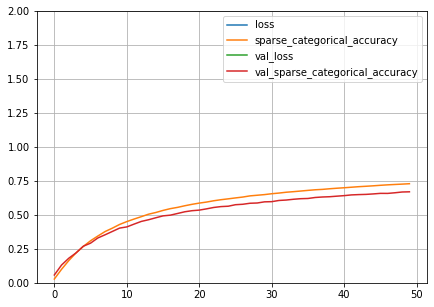

time: 148 ms (started: 2023-02-26 04:53:00 +00:00)


In [51]:
plot_loss(history)

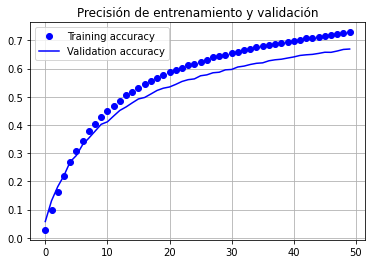

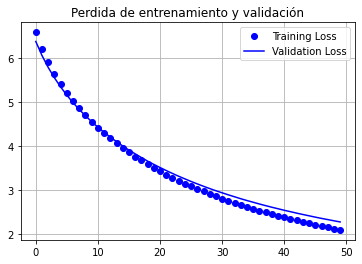

time: 265 ms (started: 2023-02-26 04:53:00 +00:00)


In [52]:
show_history(history)

In [53]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl_8g_imgs127_regular__OTSU.h5
time: 631 ms (started: 2023-02-26 04:53:00 +00:00)


## Métricas

In [54]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.08 s (started: 2023-02-26 04:53:01 +00:00)


In [55]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 6s 11ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.6720952987670898
- Test Loss: 2.2579004764556885
- time: 
- F1 score: 0.6724550067108199
- Precision score: 0.7112618013227077
- Recall:  0.6720953186689227
- Epoch: 
*********************************************************************************************************************************
time: 12 s (started: 2023-02-26 04:53:02 +00:00)


In [56]:
#runtime.unassign()

time: 333 µs (started: 2023-02-26 04:53:14 +00:00)
